In [1]:
import imageio
import skimage
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import jax
import jax.numpy as jnp

import kompressor as kom

2022-02-21 15:05:09.859022: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


### Load example image

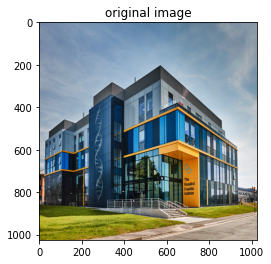

In [2]:
image = imageio.imread('data/building.jpg')
image = (skimage.transform.resize(image, (1025, 1025)) * 256.).astype(np.uint8)

plt.figure(figsize=(4,4), facecolor='w')
plt.title('original image')
plt.imshow(image)
plt.show()

original_highres = jnp.array([image])

### Select neighbourhood size for prediction model

In [3]:
padding = 1

# At padding=0 use neighbours [A-D] to predict values [0-4]

# AB    A2B
# CD    041
#       C3D

# At padding=1 use neighbours [A-P] to predict values [0-4]

# ABCD    A.B.C.D
# EFGH    .......
# IJKL    E.F2G.H
# MNOP    ..041..
#         I.J3K.L
#         .......
#         M.N.O.P

### Define a prediction model to generate maps

In [4]:
# Dummy regression predictor function just predicts the average of the neighborhood features
def predictions_fn(lowres):
    # lowres.shape == (B, H, W, C)

    # Extract the features for each neighborhood
    features = kom.image.features_from_lowres(lowres, padding)
    # features.shape == (B, H, W, N, C)
    # where N = ((padding * 2) + 1) ^ 2 is the number of surrounding neighbours included for this padding value

    # Dummy predictions are just the average values of the neighborhoods
    # << insert more intesting model here >>
    predictions = jnp.repeat(jnp.mean(features.astype(jnp.float32), axis=3, keepdims=True)
                             .astype(lowres.dtype), repeats=5, axis=3)
    # predictions.shape == (B, H, W, P, C)
    # where P = 5, the number of values that need to be predicted for each neighbourhood

    # Extract the maps from the predictions
    maps = kom.image.maps_from_predictions(predictions)
    # lrmap, udmap, cmap = maps
    # lrmap contains the merged right-pixel predictions of the neighbourhoods with the left-pixel predictions of the
    # adjacent neighbourhoods. The same is true in the udmap for up/down neighbourhoods. cmap requires no merging.
    # Number of pixels in the lowres, lrmap, udmap, and cmaps summed up equals the number of pixels in the highres image
    return maps

In [5]:
class Kompressor:
    
    def __init__(self, encode_fn, decode_fn, predictions_fn, padding):
        self.encode_fn, self.decode_fn, self.predictions_fn = encode_fn, decode_fn, predictions_fn
        self.padding = padding
        
    def encode(self, highres, levels=1, chunk=None, progress_fn=None, debug=False):

        maps = list()
        for level in range(levels):
            
            if chunk is None:
                lowres, maps_dims = kom.image.encode(self.predictions_fn, self.encode_fn, highres, padding=self.padding)
            else:
                lowres, maps_dims = kom.image.encode_chunks(self.predictions_fn, self.encode_fn, highres, padding=self.padding, chunk=chunk, progress_fn=progress_fn)
                
            if debug:
                maps.append((lowres, maps_dims, highres))
            else:
                maps.append(maps_dims)
                
            highres = lowres
            
        return lowres, maps

    def decode(self, lowres, maps, chunk=None, progress_fn=None, debug=False):

        for maps_dims in reversed(maps):
            
            if debug:
                _, maps_dims, _ = maps_dims
            
            if chunk is None:
                highres = kom.image.decode(self.predictions_fn, self.decode_fn, lowres, maps_dims, padding=self.padding)
            else:
                highres = kom.image.decode_chunks(self.predictions_fn, self.decode_fn, lowres, maps_dims, padding=self.padding, chunk=chunk, progress_fn=progress_fn)
            
            lowres = highres

        return highres

### Apply prediction model recursively to generate a pyramid of encoded maps

In [6]:
def plot_maps(title, highres, lowres, maps):

    ks = [1, 8, 64]
    
    fig, ax = plt.subplots(4, 7 + (3 * len(ks)), figsize=(36, 10), facecolor='w')

    plt.suptitle(title)

    plt.sca(ax[0, 0])
    plt.title(f'highres {highres[0].shape}')
    plt.axis('off')
    plt.axis('equal')
    plt.imshow(highres[0])

    plt.sca(ax[1, 0])
    plt.title(f'lowres {lowres[0].shape}')
    plt.axis('off')
    plt.axis('equal')
    plt.imshow(lowres[0])

    plt.sca(ax[2, 0])
    plt.axis('off')

    plt.sca(ax[3, 0])
    plt.axis('off')
    
    bins = np.arange(257)
    for midx, (label, m) in enumerate(zip(['lrmap', 'udmap', 'cmap'], maps)):

        im = kom.mapping.uint8.encode_transform_interleaved(m)
        cm = jnp.int32(kom.mapping.uint8.encode_transform_centre(m)) - 128
        
        plt.sca(ax[0, (midx*(2+len(ks)))+1])
        plt.title(f'{label} {m[0].shape}')
        sns.despine(ax=plt.gca())
        for cidx, colour in reversed(list(enumerate('rgb'))):
            plt.hist(np.array(m[0, ..., cidx]).flatten(), bins=bins, color=colour, alpha=0.25, histtype='step', density=True)
            
        plt.sca(ax[0, (midx*(2+len(ks)))+2])
        plt.title(f'{label} centre')
        sns.despine(ax=plt.gca())
        for cidx, colour in reversed(list(enumerate('rgb'))):
            plt.hist(np.array(cm[0, ..., cidx]).flatten(), bins=bins-128, color=colour, alpha=0.25, histtype='step', density=True)
        
        plt.sca(ax[0, (midx*(2+len(ks)))+3])
        plt.title(f'{label} interleave')
        sns.despine(ax=plt.gca())
        for cidx, colour in reversed(list(enumerate('rgb'))):
            plt.hist(np.array(im[0, ..., cidx]).flatten(), bins=bins, color=colour, alpha=0.25, histtype='step', density=True)
            
        for ki, k in list(enumerate(ks))[1:]:
            plt.sca(ax[0, (midx*(2+len(ks)))+3+ki])
            plt.axis('off')
        
        for cidx, cmap in enumerate(['Reds', 'Greens', 'Blues']):

            plt.sca(ax[cidx+1, (midx*(2+len(ks)))+1])
            plt.xticks([])
            plt.yticks([])
            plt.imshow(im[0, ..., cidx], vmin=0, vmax=256, cmap=cmap)
            
            if midx == 0:
                plt.ylabel(cmap)
                
            if cidx == 2:
                plt.xlabel(f'{label}\nDelta')
            
            plt.sca(ax[cidx+1, (midx*(2+len(ks)))+2])
            plt.xticks([])
            plt.yticks([])
            plt.imshow(m[0, ..., cidx], vmin=0, vmax=256, cmap='tab10')
            
            if cidx == 2:
                plt.xlabel(f'{label}\nFalse Colour')
                
            for ki, k in enumerate(ks):
                plt.sca(ax[cidx+1, (midx*(2+len(ks)))+3+ki])
                plt.xticks([])
                plt.yticks([])
                plt.imshow(im[0, ..., cidx] < (k*2))

                plt.title(f'{(jnp.sum(im[0, ..., cidx] < (k*2)) / np.prod(im[0, ..., cidx].shape)) * 100:0.1f} %')
                
                if cidx == 2:
                    plt.xlabel(f'{label}\nWithin k={k}')

    plt.tight_layout()
    plt.show()

###

### Combine smallest lowres image with stack of encoded maps to reconstruct highres image

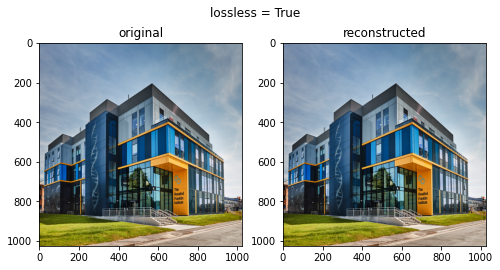

In [7]:
encode_fn = kom.mapping.uint8.encode_values
decode_fn = kom.mapping.uint8.decode_values

compressor = Kompressor(encode_fn=encode_fn, decode_fn=decode_fn, predictions_fn=predictions_fn, padding=padding)

encoded_lowres, encoded_maps = compressor.encode(original_highres, levels=3, debug=True)
reconstructed_highres        = compressor.decode(encoded_lowres, encoded_maps, debug=True)

fig, ax = plt.subplots(1, 2, figsize=(8,4), facecolor='w')

plt.suptitle(f'lossless = {np.allclose(original_highres[0], reconstructed_highres[0])}')

plt.sca(ax[0])
plt.title('original')
plt.imshow(original_highres[0])

plt.sca(ax[1])
plt.title('reconstructed')
plt.imshow(reconstructed_highres[0])

plt.show()

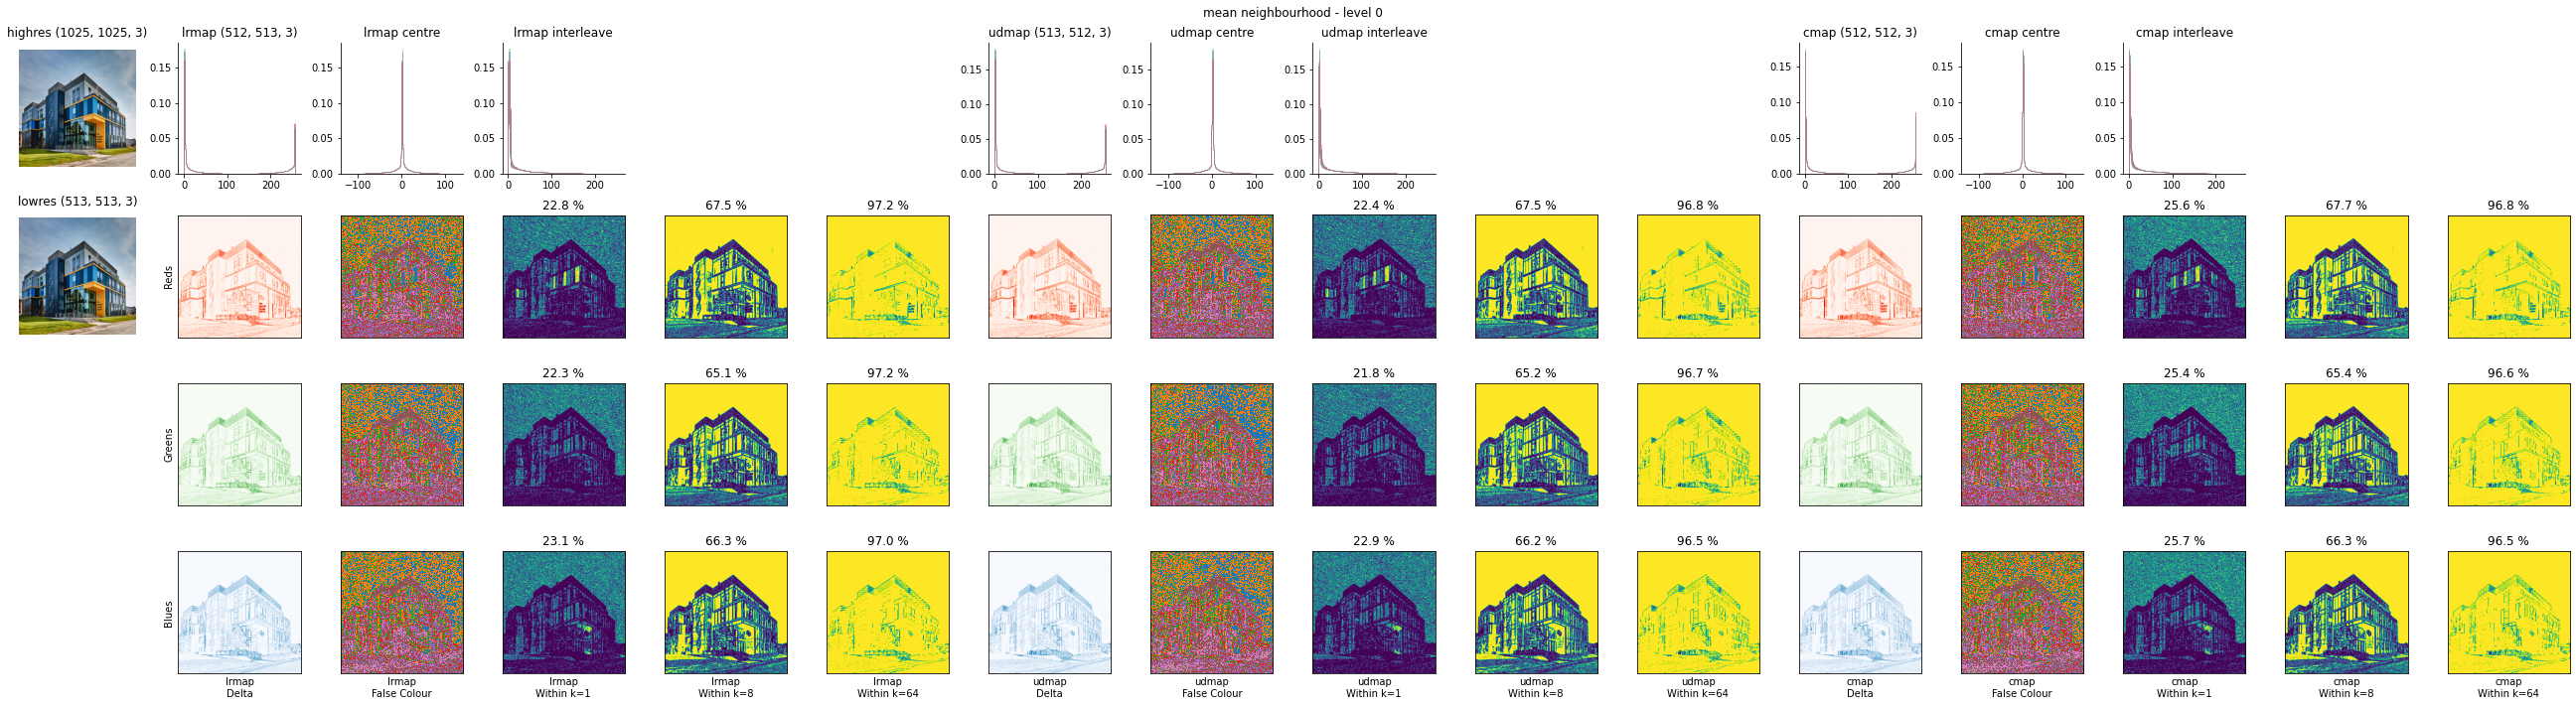

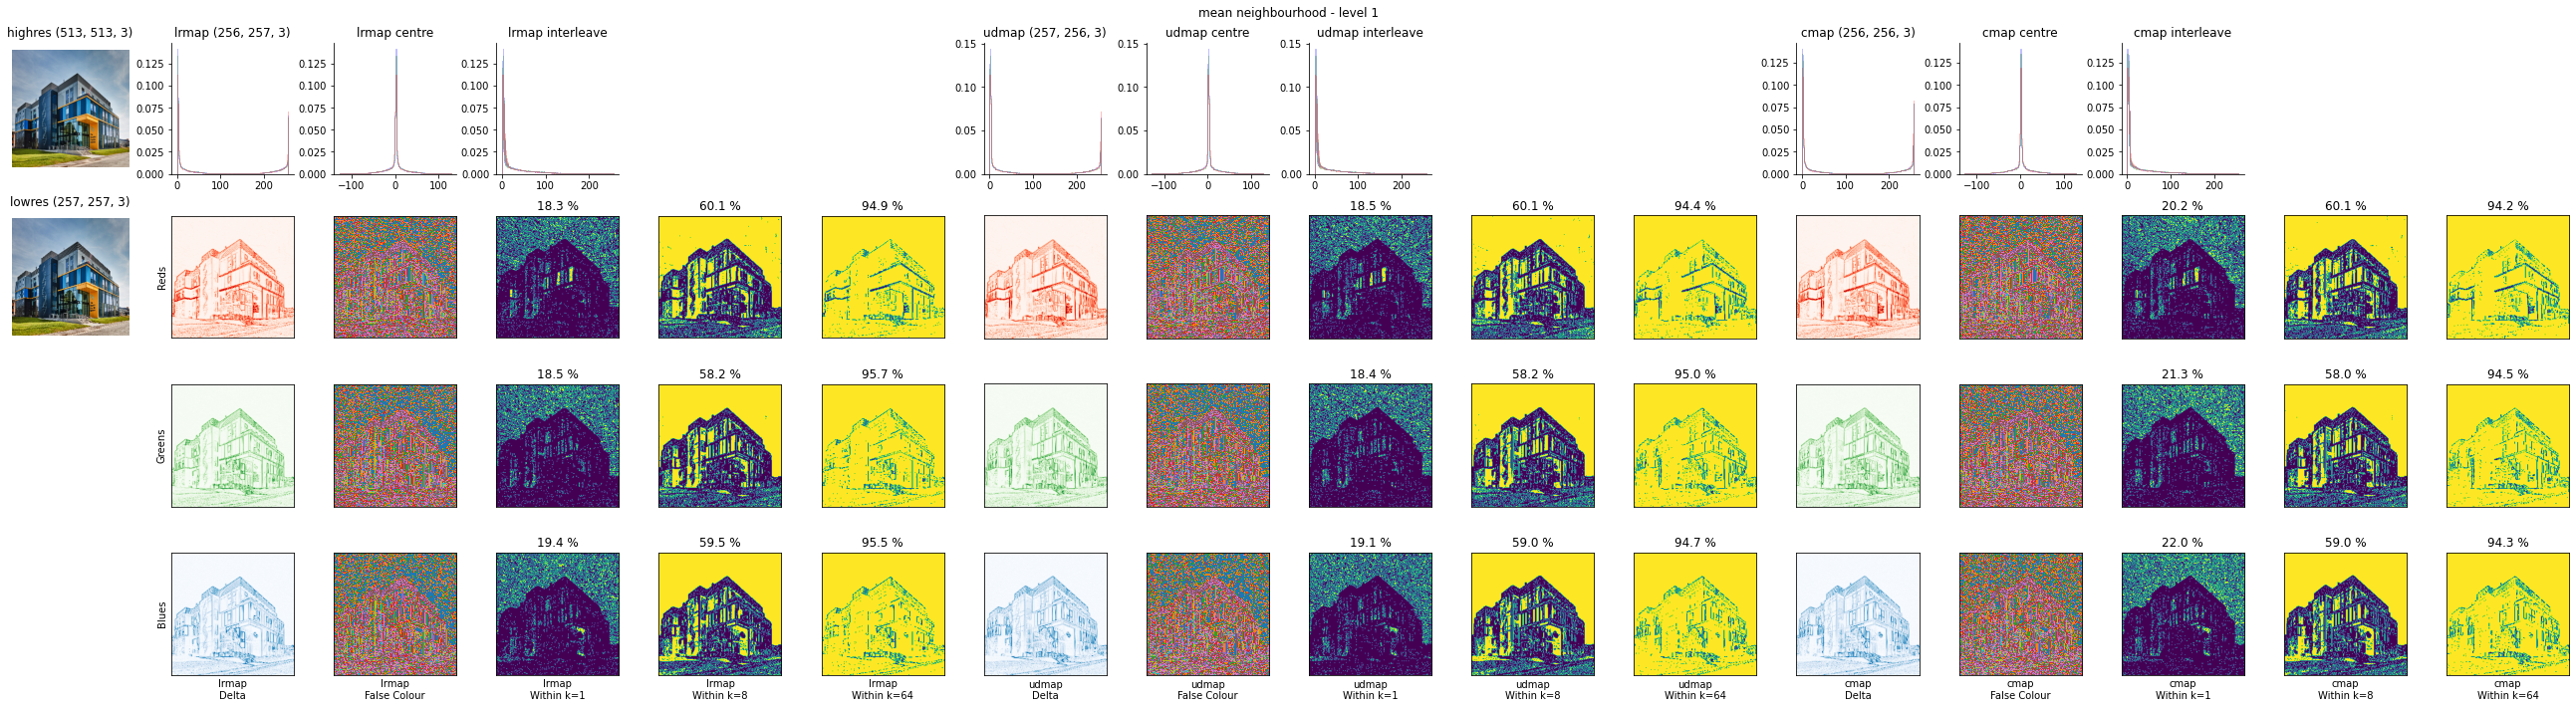

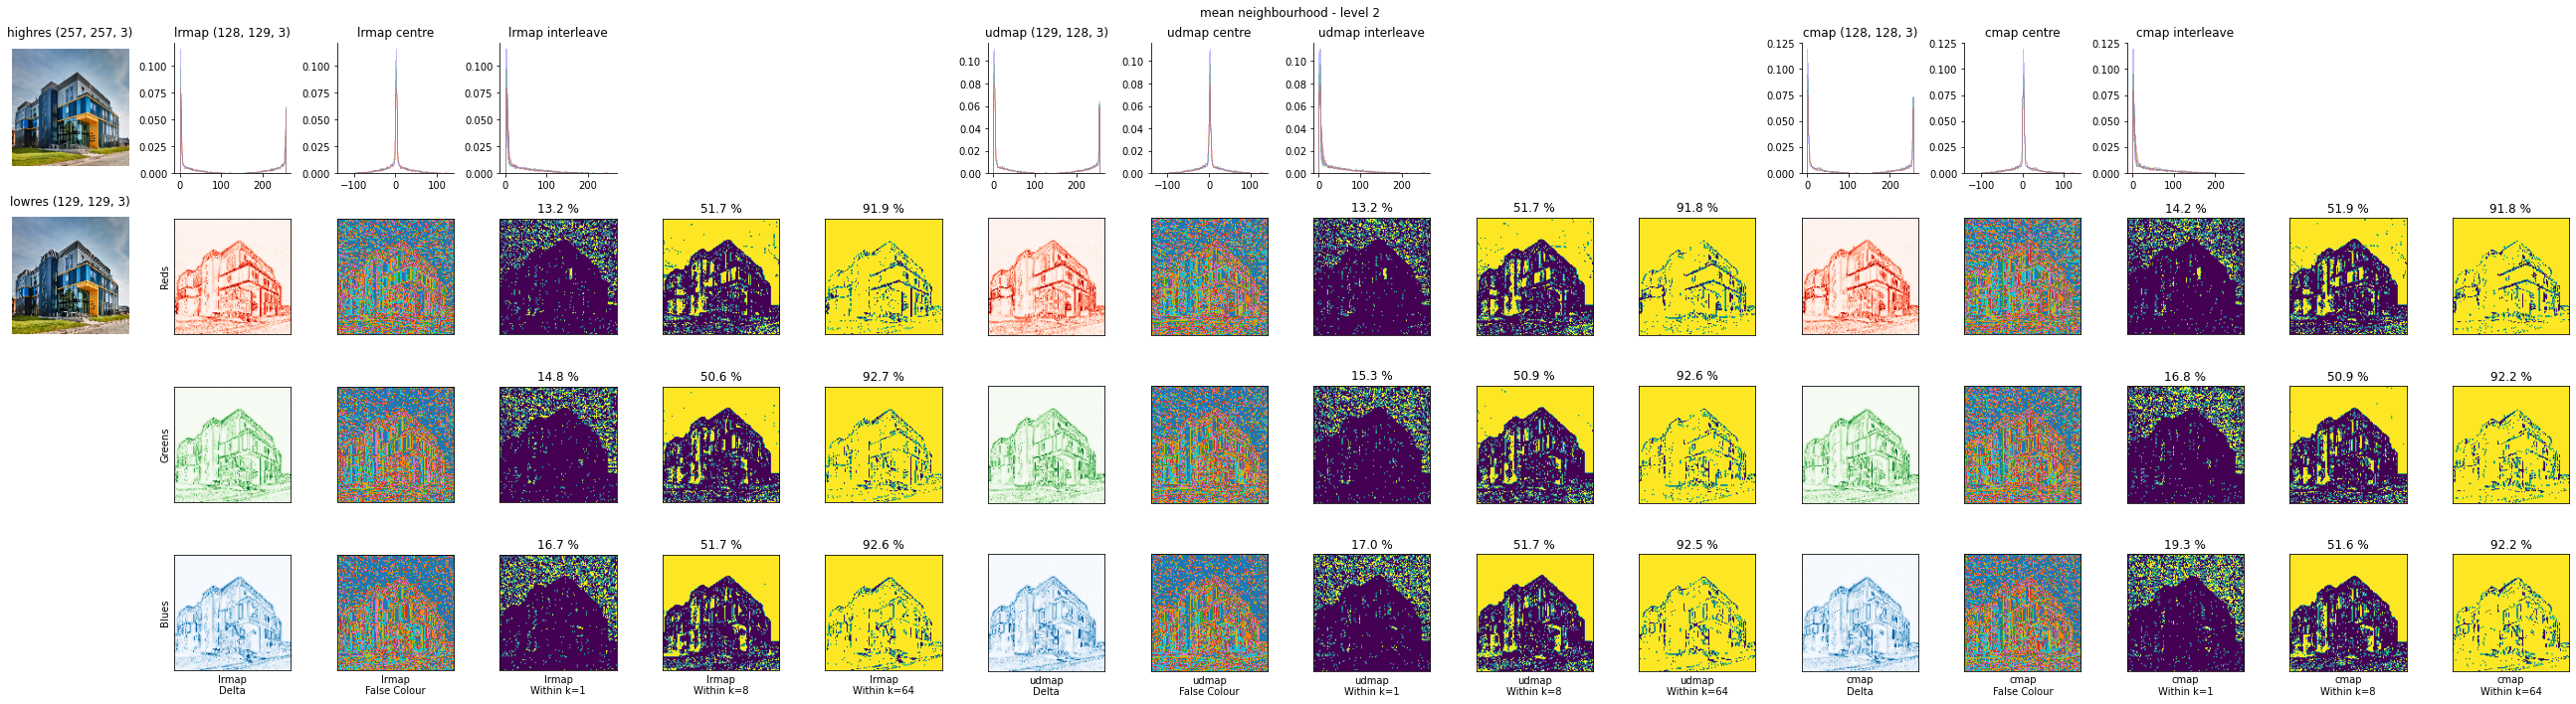

In [8]:
for level, (lowres, (maps, dims), highres) in enumerate(encoded_maps):
    plot_maps(f'mean neighbourhood - level {level}', highres, lowres, maps)